# Firefighters - Lieutenant

In [1]:
position = 'Lieutenant'
thresh = {'Lieutenant': (8, 16), 'Captain': (7,8)}
colors = ['#377eb8', '#ff7f00', '#4daf4a','#984ea3','#999999', '#e41a1c', '#dede00','#a65628', '#f781bf']

## Load the data

In [2]:
import numpy as np
import pandas as pd

def get_top_scoring(df, n):
    thresh = min(df['Combine'].nlargest(n+2))
    return df.apply(lambda x: x['Combine']>=thresh, axis=1)

def get_features(df, top_k_thresh):
    passed = df['Combine'].apply(lambda x: int(x >= 70)).rename('Passed')
    top_scoring = get_top_scoring(df, top_k_thresh[0]).rename('Top_k')
    top_scoring_2y = get_top_scoring(df, top_k_thresh[1]).rename('Top_k_2y')
    return pd.concat([top_scoring, top_scoring_2y, passed, df], axis=1)

data = pd.read_csv('../data/Firefighters.csv')  # load data set
data = data[data['Position']==position]
data.drop(['Position'],axis=1,inplace=True)
data = get_features(data, thresh[position])
data.head(5)

,Top_k,Top_k_2y,Passed,Race,Oral,Written,Combine
41,True,True,1,W,88.75,91,90.1
42,True,True,1,W,87.50,87,87.2
43,True,True,1,W,77.50,91,85.6
44,True,True,1,W,85.00,84,84.4
45,True,True,1,W,80.00,87,84.2


## Visualize distributions and adverse impact by position, race and test score

In [238]:
from scipy import stats  
import numpy as np  
import matplotlib.pylab as plt

def plot(df, title, figname):
    scores = [70,min(df[df['Top_k_2y']==1]['Combine']),min(df[df['Top_k']==1]['Combine'])]
    lines = []
    fig, ax = plt.subplots(1,3)#,sharey=True)
    for j, race in enumerate(['W','B','H',None]):
        for i, key in enumerate(['Written','Oral','Combine']):
            if j==3:
                ax[i].xaxis.set_label_position("bottom")
                ax[i].set_xlabel(key, size='large')
            if not race is None:
                ser = df[df['Race']==race][key]
            else:
                ser = df[key]
            # Plot histogram
            if (j==3):
                # Mean, passing and promotion scores
                ax[i].axvline(x=ser.mean(), color=colors[j], linestyle='dashed', linewidth=1)
                for x in scores:
                    ax[i].axvline(x=x, color='#5f5f5f', linewidth=1)
                ser.hist(density=True,ax=ax[i],color=colors[j],alpha = 0.5)
                xt = ax[i].get_xticks()  
            # Fit normal distribution
            lnspc = np.linspace(20, 100, len(ser))
            mu, stdev = stats.norm.fit(ser)
            pdf_g = stats.norm.pdf(lnspc, mu, stdev)
            if (j==3):
                ax[i].plot(lnspc, pdf_g, label="Norm",color=colors[j]) 
            ax[i].set_yticklabels([])
            ax[i].plot(lnspc, pdf_g, label="Norm",color=colors[j]) 
    plt.suptitle(title,fontsize=20,y=1.05)
    if len(figname)>0:
        fig.savefig(figname, bbox_inches="tight")
    
def get_summary(df):
    passed = df.groupby(['Race','Passed']).size().unstack().fillna(0)
    top_k = df.groupby(['Race','Top_k']).size().unstack().fillna(0)
    top_k_2y = df.groupby(['Race','Top_k_2y']).size().unstack().fillna(0)
    summary =  pd.DataFrame({
        'Race': ['B','H','W','M'], 
        'Pass': [passed[1]['B'],passed[1]['H'],passed[1]['W'],passed[1]['B']+passed[1]['H']],
        'Pass_pr': [0,0,0,0],
        'Fail': [passed[0]['B'],passed[0]['H'],passed[0]['W'],passed[0]['B']+passed[0]['H']],
        'Total': [0,0,0,0],
        'Top_k': [top_k[1]['B'],top_k[1]['H'],top_k[1]['W'],top_k[1]['B']+top_k[1]['H']],
        'Top_k_2y': [top_k_2y[1]['B'],top_k_2y[1]['H'],top_k_2y[1]['W'],top_k_2y[1]['B']+top_k_2y[1]['H']],
        'Top_k_2y_pr': [0,0,0,0],
    })
    summary['Total'] = summary['Pass'] + summary['Fail']
    summary['Pass_pr'] = 100*summary['Pass']/summary['Total']
    summary['Top_k_pr'] = 100*summary['Top_k']/summary['Total']
    summary['Top_k_2y_pr'] = 100*summary['Top_k_2y']/summary['Total']
    summary['AIR'] = (100*summary['Pass_pr']/max(summary['Pass_pr']))
    summary['AIR_top_k'] = (100*summary['Top_k_pr']/max(summary['Top_k_pr']))
    summary['AIR_top_k_2y'] = (100*summary['Top_k_2y_pr']/max(summary['Top_k_2y_pr']))
    
    return summary

In [239]:
summary = get_summary(data)
summary

,Race,Pass,Pass_pr,Fail,Total,Top_k,Top_k_2y,Top_k_2y_pr,Top_k_pr,AIR,AIR_top_k,AIR_top_k_2y
0,B,6,31.578947,13,19,0.0,3.0,15.789474,0.000000,54.315789,0.0,45.263158
1,H,3,20.000000,12,15,0.0,0.0,0.000000,0.000000,34.400000,0.0,0.000000
2,W,25,58.139535,18,43,10.0,15.0,34.883721,23.255814,100.000000,100.0,100.000000
3,M,9,26.470588,25,34,0.0,3.0,8.823529,0.000000,45.529412,0.0,25.294118


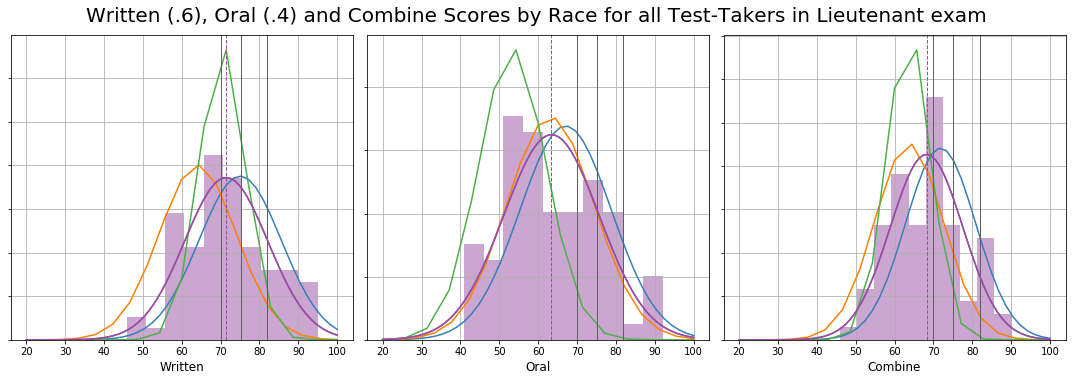

In [240]:
plt.rcParams["figure.figsize"] = [15,5]
plot(data,
     " ".join(["Written (.6), Oral (.4) and Combine Scores by Race for all Test-Takers in",position,"exam"]), 
     "".join(["../images/ff_orig_",position,"_race2score.png"]))

## Adverse impact ratio as a function of exam scaling

In [241]:
scale = np.array(range(0,11))/10

air_H, air_B, air_M = [], [], []
air_top_k_H, air_top_k_B, air_top_k_M = [], [], []
air_top_k_2y_H, air_top_k_2y_B, air_top_k_2y_M = [], [], []
for i, q in enumerate(scale):
    df = pd.read_csv('../data/Firefighters.csv')  # load data set
    df = df[df['Position']==position]
    df['Combine'] = df.apply(lambda x: (q*x.Oral+(1-q)*x.Written), axis=1)
    df = get_features(df, thresh[position])
    summary = get_summary(df)
    air_H.append(list(summary[summary.Race=='H']['AIR'])[0])
    air_B.append(list(summary[summary.Race=='B']['AIR'])[0])
    air_M.append(list(summary[summary.Race=='M']['AIR'])[0])
    air_top_k_H.append(list(summary[summary.Race=='H']['AIR_top_k'])[0])
    air_top_k_B.append(list(summary[summary.Race=='B']['AIR_top_k'])[0])
    air_top_k_M.append(list(summary[summary.Race=='M']['AIR_top_k'])[0])
    air_top_k_2y_H.append(list(summary[summary.Race=='H']['AIR_top_k_2y'])[0])
    air_top_k_2y_B.append(list(summary[summary.Race=='B']['AIR_top_k_2y'])[0])
    air_top_k_2y_M.append(list(summary[summary.Race=='M']['AIR_top_k_2y'])[0])
    

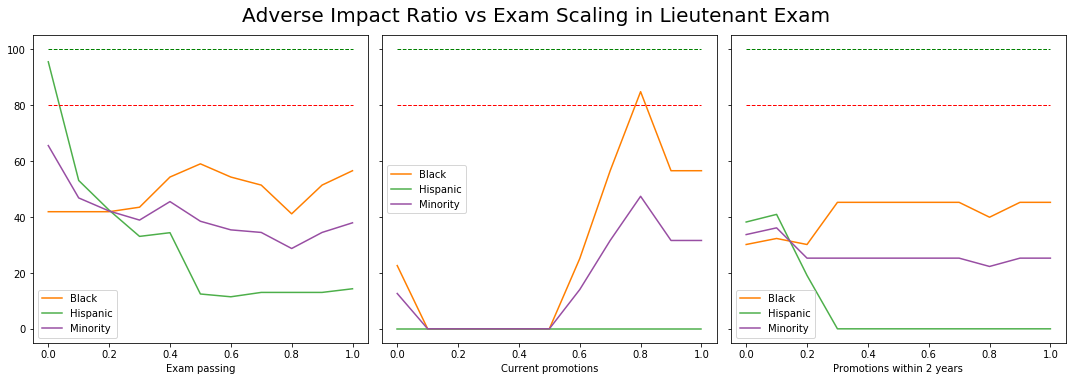

In [242]:
plt.rcParams["figure.figsize"] = [15,5]
plt.rcParams.update({'figure.autolayout': True})
fig, ax = plt.subplots(1, 3, sharey=True)

ax[0].plot(scale, air_B, label='Black', color=colors[1])
ax[0].plot(scale, air_H, label='Hispanic', color=colors[2])
ax[0].plot(scale, air_M, label='Minority', color=colors[3])
ax[0].set_xlabel("Exam passing")
ax[0].legend()
ax[0].plot([0, 1], [100, 100], 'g', linestyle='--', linewidth=1.0)
ax[0].plot([0, 1], [80, 80], 'r', linestyle='--', linewidth=1.0)

ax[1].plot(scale, air_top_k_B, label='Black', color=colors[1])
ax[1].plot(scale, air_top_k_H, label='Hispanic', color=colors[2])
ax[1].plot(scale, air_top_k_M, label='Minority', color=colors[3])
ax[1].set_xlabel("Current promotions")
ax[1].legend()
ax[1].plot([0, 1], [100, 100], 'g', linestyle='--', linewidth=1.0)
ax[1].plot([0, 1], [80, 80], 'r', linestyle='--', linewidth=1.0)

ax[2].plot(scale, air_top_k_2y_B, label='Black', color=colors[1])
ax[2].plot(scale, air_top_k_2y_H, label='Hispanic', color=colors[2])
ax[2].plot(scale, air_top_k_2y_M, label='Minority', color=colors[3])
ax[2].set_xlabel("Promotions within 2 years")
ax[2].legend()
ax[2].plot([0, 1], [100, 100], 'g', linestyle='--', linewidth=1.0)
ax[2].plot([0, 1], [80, 80], 'r', linestyle='--', linewidth=1.0)

plt.suptitle("".join(["Adverse Impact Ratio vs Exam Scaling in ",position," Exam"]), fontsize=20, y=1.05)
plt.show()
fig.savefig("".join(["../images/ff_orig_",position,"_airatio.png"]), bbox_inches="tight")

## Implement Fairess Awareness

### IBM 360 Fairness Kit (Disparate Impact Removal)

In [243]:
from sklearn.linear_model import LogisticRegression

from aif360.datasets import StandardDataset
from aif360.algorithms.preprocessing import DisparateImpactRemover

protected = 'Majority'
df = data[['Oral','Written','Combine','Passed']].copy()
df[protected] = data.apply(lambda x: int(x['Race']=='W'), axis=1)

max_oral, max_written = max(df['Oral']), max(df['Written'])
ds_orig = StandardDataset(
        df=df, 
        label_name='Passed',favorable_classes=[1],
        protected_attribute_names=[protected], privileged_classes=[[1]],
        features_to_keep=['Oral','Written'])

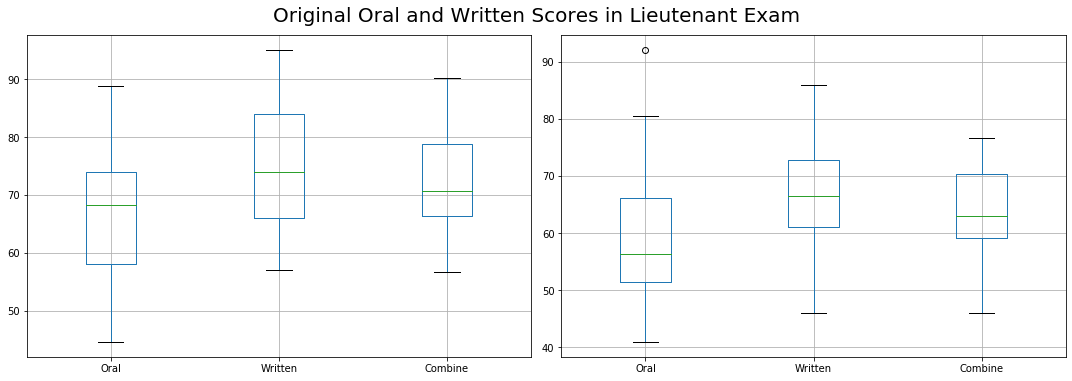

In [244]:
fig, ax = plt.subplots(1,2) # create figure and axes
a = df[df['Majority']==1].boxplot(column=['Oral', 'Written', 'Combine'], ax=ax.flatten()[0])
b = df[df['Majority']==0].boxplot(column=['Oral', 'Written', 'Combine'], ax=ax.flatten()[1])
plt.tight_layout() 
plt.suptitle("Original Oral and Written Scores in Lieutenant Exam", fontsize=20, y=1.05)
plt.show()

#### Check for bias in the original data

In [245]:
from aif360.metrics import BinaryLabelDatasetMetric
priv, unpriv = [{protected: 1}], [{protected: 0}]
metric = BinaryLabelDatasetMetric(ds_orig, privileged_groups=priv, unprivileged_groups=unpriv)

from aif360.explainers import MetricJSONExplainer
expl_json = MetricJSONExplainer(metric).disparate_impact()

import json
expl = json.loads(expl_json)
pd.set_option('display.max_colwidth', -1)
df_expl = pd.DataFrame([[key, expl[key]] for key in expl])
df_expl.style.set_properties(**{'text-align': 'left'})

,0,1
0,metric,Disparate Impact
1,message,Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.4552941176470588
2,numPositivePredictionsUnprivileged,9
3,numUnprivileged,34
4,numPositivePredictionsPrivileged,25
5,numPrivileged,43
6,description,Computed as the ratio of rate of favorable outcome for the unprivileged group to that of the privileged group.
7,ideal,The ideal value of this metric is 1.0 A value < 1 implies higher benefit for the privileged group and a value >1 implies a higher benefit for the unprivileged group.


#### Run Disparate Impact Remover with Different Repair Levels 

In [246]:
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC as SVM

from tqdm import tqdm

def computeDIs(df, repair_levels, q):
    
    max_oral, max_written = max(df['Oral']), max(df['Written'])
    scaler = MinMaxScaler(copy=False) # Scale values between 0 and 1
    train = StandardDataset(
            df=df.copy(), 
            label_name='Passed',favorable_classes=[1],
            protected_attribute_names=[protected], privileged_classes=[[1]],
            features_to_keep=['Oral','Written'])
    train.features = scaler.fit_transform(train.features)
    index = train.feature_names.index(protected)

    DIs = []
    metrics = []
    features = []
    models = []
    for level in tqdm(repair_levels):

        di = DisparateImpactRemover(repair_level=level)
        train_repd = di.fit_transform(train)
        
        X_tr = np.delete(train_repd.features, index, axis=1)
        y_tr = train_repd.labels.ravel()
        
        lmod = LogisticRegression(class_weight='balanced', solver='liblinear')
        lmod.fit(X_tr, y_tr)
        models.append(lmod)
        
        train_repd_pred = train_repd.copy()
        train_repd_pred.labels = lmod.predict(X_tr)
        
        p = [{protected: 1}]
        u = [{protected: 0}]
        cm = BinaryLabelDatasetMetric(train_repd_pred, privileged_groups=p, unprivileged_groups=u)
        
        DIs.append(cm.disparate_impact())
        metrics.append(cm)
        
        feat_df = pd.DataFrame(train_repd_pred.features, columns=['repd_Oral','repd_Written','repd_Passed'])
        feat_df['repd_Written'] = feat_df['repd_Written']*max_written
        feat_df['repd_Oral'] = feat_df['repd_Oral']*max_oral
        feat_df['repd_Combine'] = feat_df.apply(lambda x: (1-q)*x['repd_Oral']+q*x['repd_Written'], axis=1)
        
        features.append(pd.concat([df,feat_df],axis=1))
    
    return DIs, metrics, features, models


100%|██████████| 11/11 [00:00<00:00, 31.87it/s]


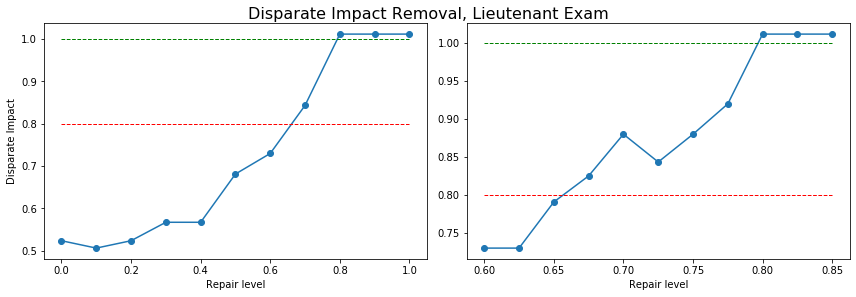

In [247]:
import matplotlib.pyplot as plt

q = 0.6 # Written weight
repair_levels = np.linspace(0, 1, 11)
DIs,metrics,features,models = computeDIs(df, repair_levels, q)

plt.rcParams["figure.figsize"] = [12,4]
fig, ax = plt.subplots(1,2)
ax[0].plot(repair_levels, DIs, marker='o')
ax[0].plot([0, 1], [1, 1], 'g', linestyle='--', linewidth=1.0)
ax[0].plot([0, 1], [0.8, 0.8], 'r', linestyle='--', linewidth=1.0)
ax[0].set_ylabel("Disparate Impact")
ax[0].set_xlabel("Repair level")

repair_levels = np.linspace(0.6, 0.85, 11)
DIs,metrics,features,models = computeDIs(df, repair_levels, q)

ax[1].plot(repair_levels, DIs, marker='o')
ax[1].plot([0.6, 0.85], [1, 1], 'g', linestyle='--', linewidth=1.0)
ax[1].plot([0.6, 0.85], [0.8, 0.8], 'r', linestyle='--', linewidth=1.0)
ax[1].set_xlabel("Repair level")

plt.suptitle("".join(["Disparate Impact Removal, ",position," Exam"]), fontsize=16, y=1.02)
plt.show()
fig.savefig("".join(["../images/ff_orig_",position,"_diremoval.png"]), bbox_inches="tight")


### Apply Disparate Impact Removal with Repair Level 0.675

#### Apply Disparate Impact Removal on Original Data

In [62]:
q = 0.6 # Written weight
repair_levels = [0.675]
DIs,metrics,features,models = computeDIs(df, repair_levels, q)

import json
expl = json.loads(MetricJSONExplainer(metrics[0]).disparate_impact())
pd.set_option('display.max_colwidth', -1)
df_expl = pd.DataFrame([[key, expl[key]] for key in expl])
df_expl.style.set_properties(**{'text-align': 'left'})

100%|██████████| 1/1 [00:00<00:00, 55.43it/s]


,0,1
0,metric,Disparate Impact
1,message,Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.8248081841432225
2,numPositivePredictionsUnprivileged,15
3,numUnprivileged,34
4,numPositivePredictionsPrivileged,23
5,numPrivileged,43
6,description,Computed as the ratio of rate of favorable outcome for the unprivileged group to that of the privileged group.
7,ideal,The ideal value of this metric is 1.0 A value < 1 implies higher benefit for the privileged group and a value >1 implies a higher benefit for the unprivileged group.


In [42]:
#dir(train_675_repd)

## Generate random samples

To generate correlated normally distributed random samples, one can 
* first generate uncorrelated samples, and 
* then multiply them by a matrix C such that CCT=R, where R is the desired covariance matrix.

C can be created, for example, by using the Cholesky decomposition of R, or from the eigenvalues and eigenvectors of R. 
(Reference: https://scipy-cookbook.readthedocs.io/items/CorrelatedRandomSamples.html)

### Generate Sample Data

In [164]:
from scipy.stats import truncnorm, norm
from scipy.linalg import cholesky

columns = ["Oral", "Written"]
n_maj, n_min = 43, 34
#n_maj, n_min = 60, 40
q = .6

def generate_data(df, n):
    L = np.linalg.cholesky(df.cov())
    uncorrelated = np.random.standard_normal((2, n))
    mean = [df[columns[0]].mean(), df[columns[1]].mean()]
    correlated = np.dot(L, uncorrelated) + np.array(mean).reshape(2, 1)
    return np.array(correlated).transpose()[:n]

def generate_sample_df():
    # Majority
    sample_maj = pd.DataFrame(generate_samples(df[df['Majority']==1][columns], n_maj), columns=columns)
    sample_maj['Majority'] = 1
    # Minority
    sample_min = pd.DataFrame(generate_samples(df[df['Majority']==0][columns], n_min), columns=columns)
    sample_min['Majority'] = 0
    # Concat
    sample = pd.concat([sample_maj, sample_min],ignore_index=True).apply(np.random.permutation, axis=0) 
    sample = sample[sample["Written"]<=100][sample["Oral"]<=100]
    sample['Combine'] = sample.apply(lambda x: (1-q)*x['Oral'] + q*x['Written'], axis=1)
    sample['Passed'] = 0
    return sample

### Apply Disparate Impact Removal

In [214]:
import warnings
warnings.filterwarnings('ignore')

q = 0.6 # Written weight
repair_levels = [0.675]
DIs,metrics,features,models = computeDIs(df, repair_levels, q)

def generate_fair_sample():
    # Generate sample
    sample = generate_sample_df().sort_values(['Combine'],ascending=False)
    sample.head()

    # Create scaled dataset
    sample_ds = StandardDataset(
            df=sample.copy(), 
            label_name='Passed',favorable_classes=[1],
            protected_attribute_names=[protected], privileged_classes=[[1]],
            features_to_keep=['Oral','Written'])
    scaler = MinMaxScaler(copy=False)
    sample_ds.features = scaler.fit_transform(sample_ds.features)

    # Predict label
    sample_X = np.delete(sample_ds.features, 2, axis=1)
    sample_ds.labels = models[0].predict(sample_X)
    sample['Passed'] = sample_ds.labels
    
    min_pass = min(sample[sample['Passed']==1]['Combine'])
    max_fail = max(sample[sample['Passed']==0]['Combine'])
    
    # Measure di
    p = [{protected: 1}]
    u = [{protected: 0}]
    cm = BinaryLabelDatasetMetric(sample_ds, privileged_groups=p, unprivileged_groups=u)
    
    return sample, cm, min_pass, max_fail

100%|██████████| 1/1 [00:00<00:00, 37.10it/s]


### Measure Disparate Impact on Sample Datasets

In [249]:
result = pd.DataFrame()

sample_result = []
for i in range(0,10):
    sample, metric, min_pass, max_fail = generate_fair_sample()
    expl = json.loads(MetricJSONExplainer(metric).disparate_impact())
    sample_result.append([
        di.disparate_impact(),
        expl['numUnprivileged'],
        expl['numPositivePredictionsUnprivileged'],
        expl['numPrivileged'],
        expl['numPositivePredictionsPrivileged'],
        min_pass,
        max_fail,
        max_fail-min_pass
    ])
    
sample_result = pd.DataFrame(sample_result, 
         columns=['DI','Num_minor','Pass_minor','Num_major','Pass_major','Min_pass','Max_fail','Diff_pass'])
sample_result

,DI,Num_minor,Pass_minor,Num_major,Pass_major,Min_pass,Max_fail,Diff_pass
0,0.812755,33.0,20.0,43.0,27.0,64.531461,66.244664,1.713203
1,0.812755,34.0,26.0,43.0,35.0,64.827667,65.831394,1.003728
2,0.812755,34.0,29.0,43.0,34.0,60.151948,59.932728,-0.219220
3,0.812755,33.0,23.0,43.0,25.0,63.235173,64.754049,1.518876
4,0.812755,34.0,24.0,43.0,32.0,63.259785,62.802541,-0.457244
5,0.812755,34.0,23.0,42.0,28.0,64.541596,63.668898,-0.872698
6,0.812755,34.0,24.0,43.0,38.0,59.263608,60.314511,1.050903
7,0.812755,34.0,11.0,42.0,24.0,66.573417,66.798352,0.224936
8,0.812755,34.0,33.0,41.0,35.0,57.911241,57.155591,-0.755650
9,0.812755,34.0,29.0,42.0,30.0,60.789013,61.961268,1.172255


In [250]:
sample_result['Diff_pass'].describe()

count    10.000000
mean     0.437909 
std      0.969008 
min     -0.872698 
25%     -0.397738 
50%      0.614332 
75%      1.141917 
max      1.713203 
Name: Diff_pass, dtype: float64

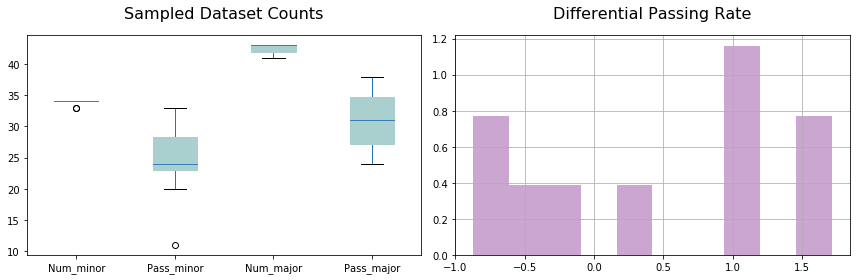

In [262]:
plt.rcParams["figure.figsize"] = [12,4]
fig, ax = plt.subplots(1,2) # create figure and axes
sample_result['Diff_pass'].hist(density=True,ax=ax[1],color=colors[3],alpha = 0.5)
ax[1].set_title("Differential Passing Rate", fontsize=16, y=1.05)

props = dict(boxes="#aacfcf", medians=colors[0])
sample_result[['Num_minor', 'Pass_minor', 'Num_major', 'Pass_major']].plot.box(color=props, patch_artist=True, ax=ax[0])
ax[0].set_title("Sampled Dataset Counts", fontsize=16, y=1.05)

plt.tight_layout() 
plt.show()
fig.savefig("../images/ff_Lieutenant_sampled.png", bbox_inches="tight")